In [1]:
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
from a_star import *
from magic import ordinator
from scipy import ndimage
import pickle
import matplotlib.pyplot as plt
import pickle

Missing 2 nodes to close the polygon; min_dist = 1.764906663334693


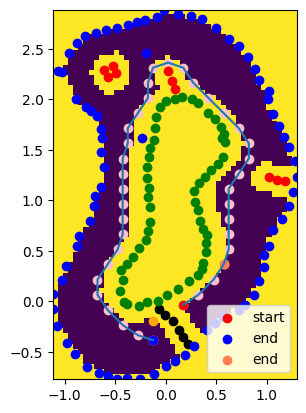

In [2]:
with open("../pathfinding/SLAM20240207_142908.pickle", 'rb') as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:
# with open(r"SLAM20240121_162038.pickle", "rb") as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:

    e = pickle.load(input_file)

positions = np.array(e['positions'])
ids = e['ids']
ids = np.array(ids)
robot_pose=e['robot_pose']


path_pos=np.loadtxt("../path_coords.txt")




positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)
mask_obstacle = (ids % 3 == 1) & (ids >= 100) & (ids <= 1000)
mask_start_line = (ids < 100)


ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]
positions_obstacle = positions_array[mask_obstacle]
positions_start_line = positions_array[mask_start_line]




# distinguish internal external obstable and start markers
# positions_array = np.array(self.positions)

# mask_external = (ids % 3 == 2) & (
#     ids >= 100) & (ids <= 1000)
# mask_internal = (ids % 3 == 0) & (
#     ids >= 100) & (self.ids <= 1000)
# mask_obstacle = (self.ids % 3 == 1) & (
#     self.ids >= 100) & (self.ids <= 1000)
# mask_start_line = (self.ids < 100)

# # ids_external = ids[mask_external]
# # ids_internal = ids[mask_internal]

# positions_external = positions_array[mask_external]
# positions_internal = positions_array[mask_internal]
# positions_obstacle = positions_array[mask_obstacle]
# positions_start_line = positions_array[mask_start_line]

pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext, max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

max_x = np.max(external_ordered[:, 0])
max_y = np.max(external_ordered[:, 1])
min_x = np.min(external_ordered[:, 0])
min_y = np.min(external_ordered[:, 1])

delta_x = max_x-min_x
delta_y = max_y-min_y
# center_x = min_x+delta_x/2
# center_y = min_y+delta_y/2
spatial_step=0.05
n_x = int(delta_x/spatial_step)
n_y = int(delta_y/spatial_step)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)

x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])),
                max(np.concatenate(
                    [external_ordered[:, 0], internal_ordered[:, 0]])),
                n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])),
                max(np.concatenate(
                    [external_ordered[:, 1], internal_ordered[:, 1]])),
                n_y)

# X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask_internal = np.array([[int_ordered_poly.contains(Point(x[i], y[j]))
                            for i in range(n_x)]
                            for j in range(n_y)])
mask_external = np.array([[not ext_ordered_poly.contains(Point(x[i], y[j]))
                            for i in range(n_x)]
                            for j in range(n_y)])

# erosion to avoid stepping over the track
mask_internal = ndimage.binary_dilation(mask_internal, iterations=4)

mask = mask_internal + mask_external

# addition of obstacles markers and start line to split the track
mask_line_obs = np.zeros_like(mask, dtype=bool)
for x_i, y_i in np.vstack((positions_start_line, positions_obstacle)):
    mask_line_obs += np.array([[Point(x_i, y_i).buffer(0.15).contains(Point(x[i], y[j]))
                                for i in range(n_x)] for j in range(n_y)])

mask = mask+mask_line_obs

plt.imshow(mask, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)])

for p in path_pos:
    plt.scatter(*p, c='pink')

plt.scatter(*path_pos[0], c='red', label='start')
plt.scatter(*path_pos[-1], c='blue', label='end')
plt.scatter(*path_pos[3], c='coral', label='end')



plt.plot(path_pos[:,0], path_pos[:,1])

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)



plt.scatter(*robot_pose, color='orange')
# plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [3]:
def find_extremes(ids, positions):
    mask_start_line = (ids < 100) & (ids > 0)
    positions_start_line = positions[mask_start_line]
    pos_start_line_ordered = np.array(
        ordinator(positions_start_line, max_distance=0.6))  # ordinator has higher max_dist because is not a closed loop
    first = pos_start_line_ordered[0]
    last = pos_start_line_ordered[-1]

    radius = np.sqrt((first[0]-last[0])**2+(last[1]-first[1])**2)
    print("first and last:", first, last, radius)
    return (first, last, radius)

def get_centers( first, last, r):
    x1, y1 = first
    x2, y2 = last
    r1 = r2 = r
    centerdx = x1 - x2
    centerdy = y1 - y2
    R = np.sqrt(centerdx**2 + centerdy**2)
    if not (abs(r1 - r2) <= R and R <= r1 + r2):
        """ No intersections """
        return []

    """ intersection(s) should exist """
    R2 = R**2
    R4 = R2**2
    a = (r1**2 - r2**2) / (2 * R2)
    r2r2 = r1**2 - r2**2
    c = np.sqrt(2 * (r1**2 + r2**2) / R2 - (r2r2**2) / R4 - 1)

    fx = (x1 + x2) / 2 + a * (x2 - x1)
    gx = c * (y2 - y1) / 2
    ix1 = fx + gx
    ix2 = fx - gx

    fy = (y1 + y2) / 2 + a * (y2 - y1)
    gy = c * (x1 - x2) / 2
    iy1 = fy + gy
    iy2 = fy - gy

    return [np.array([ix1, iy1]), np.array([ix2, iy2])]

def get_arrival_coords(ids, positions):
    intersect_1, intersect_2 = get_centers(*find_extremes(ids, positions))
    d1 = np.sqrt(np.sum((robot_pose-intersect_1)**2))
    d2 = np.sqrt(np.sum((robot_pose-intersect_2)**2))

    if d1 < d2:
        target_start = intersect_1
        target_end = intersect_2
    else:
        target_start = intersect_2
        target_end = intersect_1

    print(target_start, target_end)
    return (target_start, target_end)

In [4]:
ext_1, ext_2, rad=find_extremes(ids, positions)

first and last: [ 0.1346241  -0.28343922] [-0.06288446 -0.07262555] 0.2888806583371519


In [5]:
target_start, target_end=get_arrival_coords(ids, positions)

first and last: [ 0.1346241  -0.28343922] [-0.06288446 -0.07262555] 0.2888806583371519
[-0.14670017 -0.34907982] [ 0.21843981 -0.00698495]


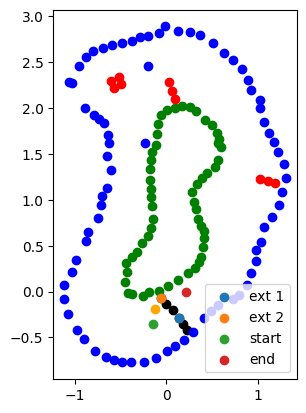

In [6]:

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(*ext_1, label='ext 1')
plt.scatter(*ext_2, label='ext 2')

plt.scatter(*target_start, label='start')
plt.scatter(*target_end, label='end')

plt.scatter(*robot_pose, color='orange')
# plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [7]:
def meter_to_matrix( x, y):
    index_x = int(abs(min_x-x)/spatial_step)
    index_y = int(abs(min_y-y)/spatial_step)
    return (index_x, index_y)

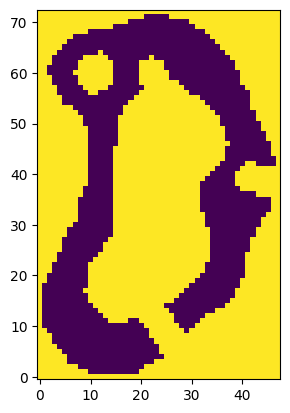

In [8]:
plt.imshow(mask, origin='lower')

TypeError: 'bool' object is not iterable

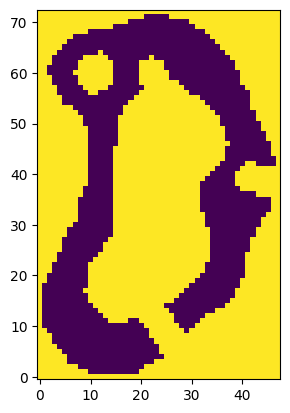

In [9]:
path=astar(mask,  meter_to_matrix(*target_start), meter_to_matrix(*target_end))
maze_plot(mask , meter_to_matrix(*target_start), meter_to_matrix(*target_end))

In [ ]:
def matrix_to_meter( index_x, index_y):
    x = spatial_step*index_x+min_x#+spatial_step/2
    y = spatial_step*index_y+min_y#+spatial_step/2
    return (x, y)

In [ ]:

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

for p in path[::3]:
    plt.scatter(*matrix_to_meter(*p))

plt.scatter(*ext_1, label='ext 1')
plt.scatter(*ext_2, label='ext 2')

plt.scatter(*target_start, label='start')
plt.scatter(*target_end, label='end')

plt.scatter(*robot_pose, color='orange')
# plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.legend()
plt.show()